# Visualizing Spatial Data 

## Introduction

R has to plotting systens:
   * the traditional plottying system
   * Trellis Graphics system (package lattice) that builds upon the grid graphical model
    
 The **sp** package has a plot method that includes plot, image, lines, points, etc. and a 'new' method called ssplot for conditioning plots.
 
### The traditional plot system
#### Plotting points, lines, polygons, and grids

In [3]:
library(sp)
library(sf)
library(stars)
library(lattice)
library(gstat)

In [4]:
setwd("/home/erick/spatial-data-with-r")
#Sys.setlocale(locale="C")

data(meuse)

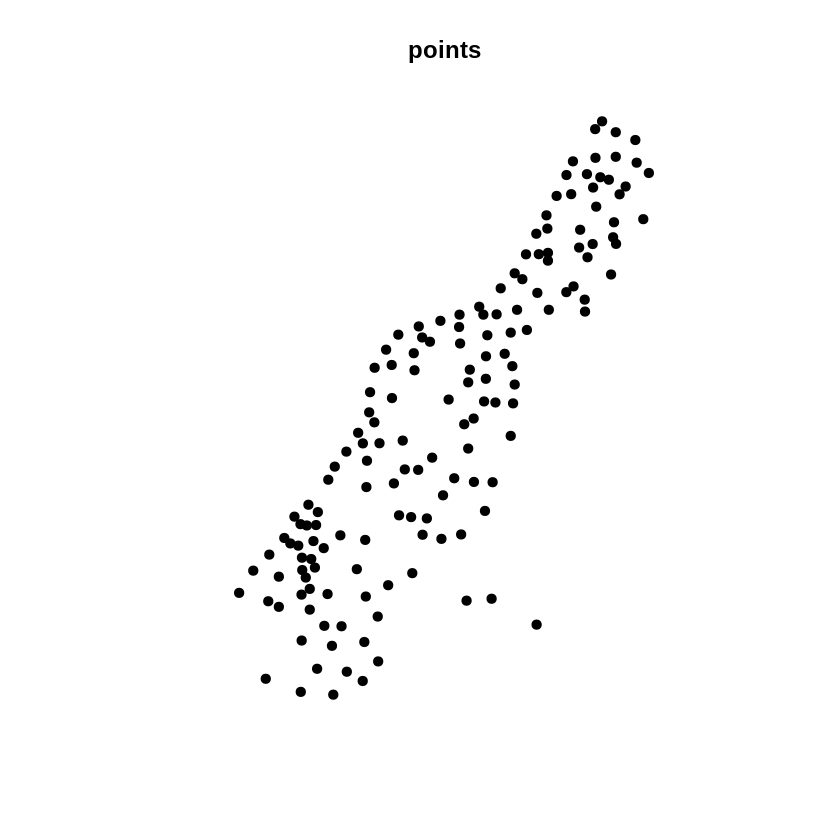

In [6]:
coordinates(meuse) <- c("x", "y")
plot(meuse, pch = 19)
title("points")

The **SpatialPointsDataFrame** object used was created from a data.frame and the plot method shows the points with defaut symbols

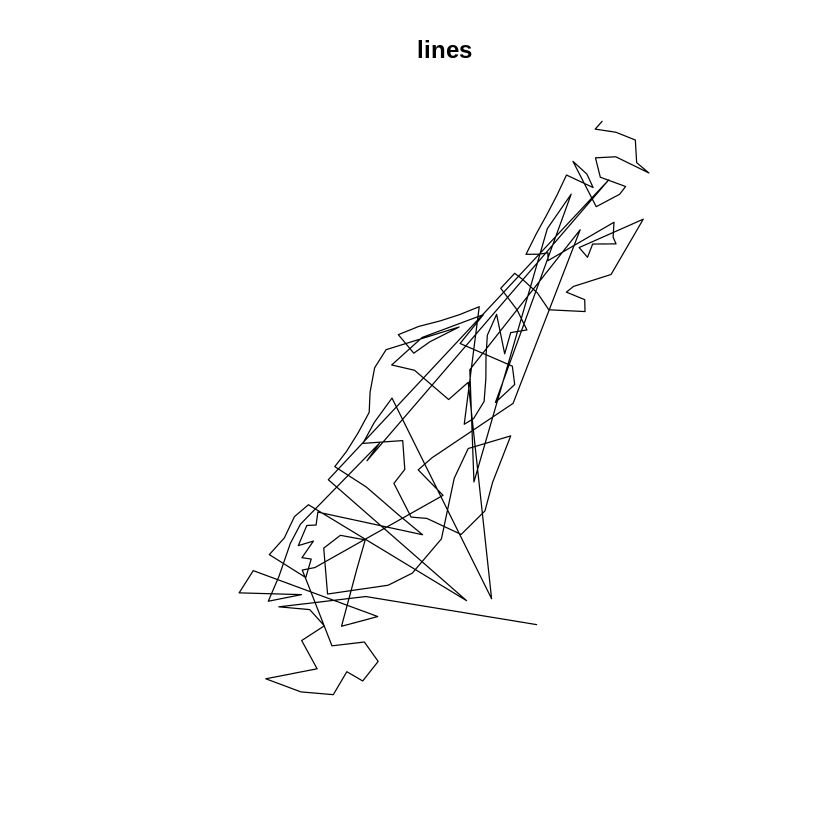

In [7]:
cc <- coordinates(meuse)
m.sl <- SpatialLines(list(Lines(list(Line(cc)), "1")))
plot(m.sl)
title("lines")

* **SpatialLines** Object is made by jointing up the points in sequence, and plot draws the results

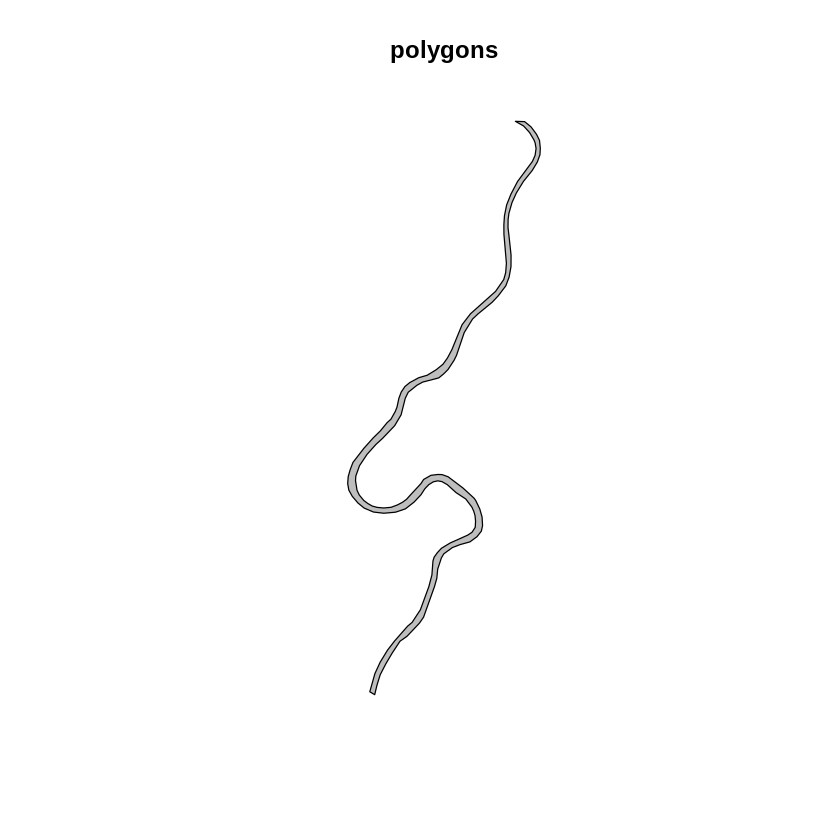

In [8]:
data(meuse.riv)
meuse.lst <- list(Polygons(list(Polygon(meuse.riv)),"meuse.riv"))

meuse.sr <- SpatialPolygons(meuse.lst)
plot(meuse.sr, col = "grey")
title("polygons")


* Finally, let's convert the Meuse bank into **SpatialPixels** object and display it using the image method with all cell set to 'grey'

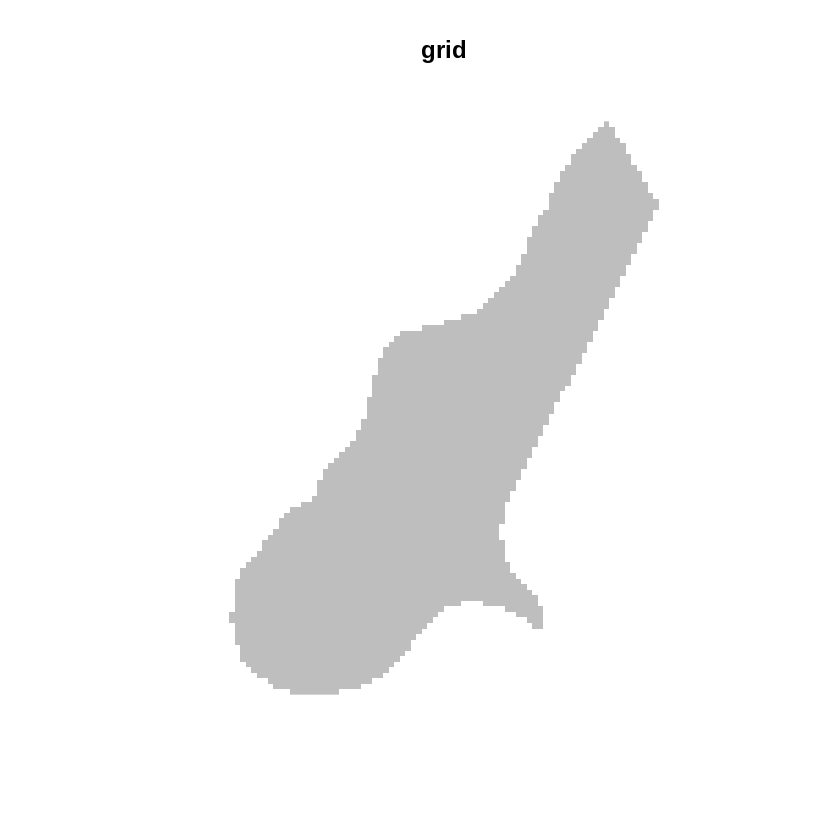

In [9]:
data(meuse.grid)
coordinates(meuse.grid) <- c("x", "y")
meuse.grid <- as(meuse.grid, "SpatialPixels")
image(meuse.grid, col = "grey")
title("grid")

* On each map, one unit in x-direction equals one unit in the y-direction. This is the default when coodinate reference system is not **longlat** or is unknown.

* Maps become increasingly better as we add elements changing **add** to TRUE.

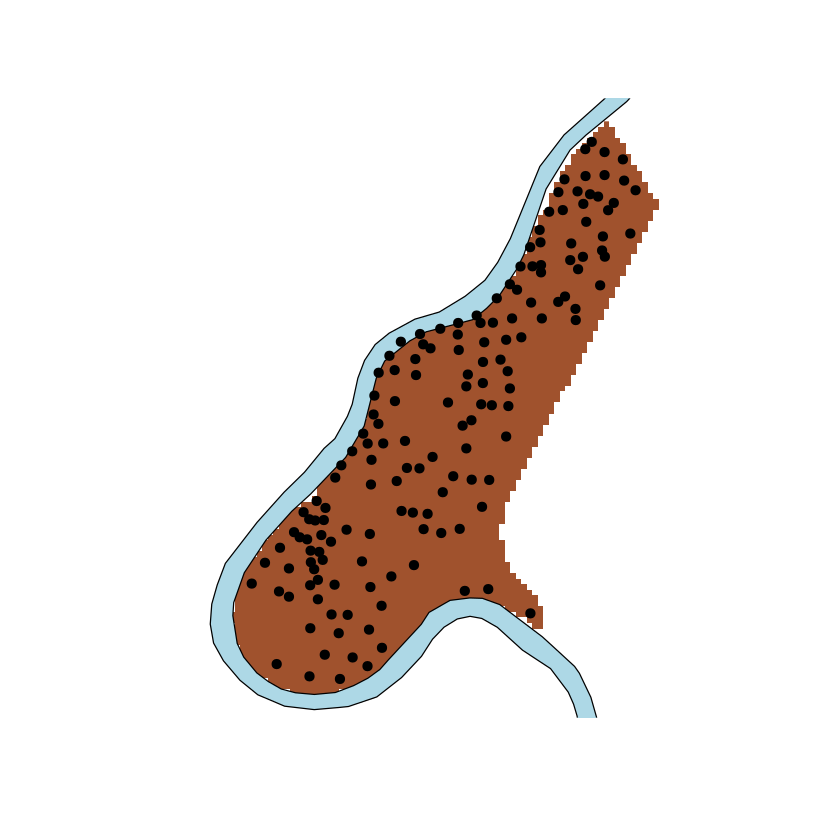

In [10]:
# Adding the grey grid first
image(meuse.grid, col = "sienna")
## Adding the river as polygon
plot(meuse.sr, col = "lightblue", add = TRUE)
## Adding the points
plot(meuse, pch = 19, add = TRUE)

## Axes and Layout Elements

Maps often do not have axes and othen geographical references are often represented as administrative boundaries, rivers, coast lines, etc. However, we can add axis by changing the option **axes**

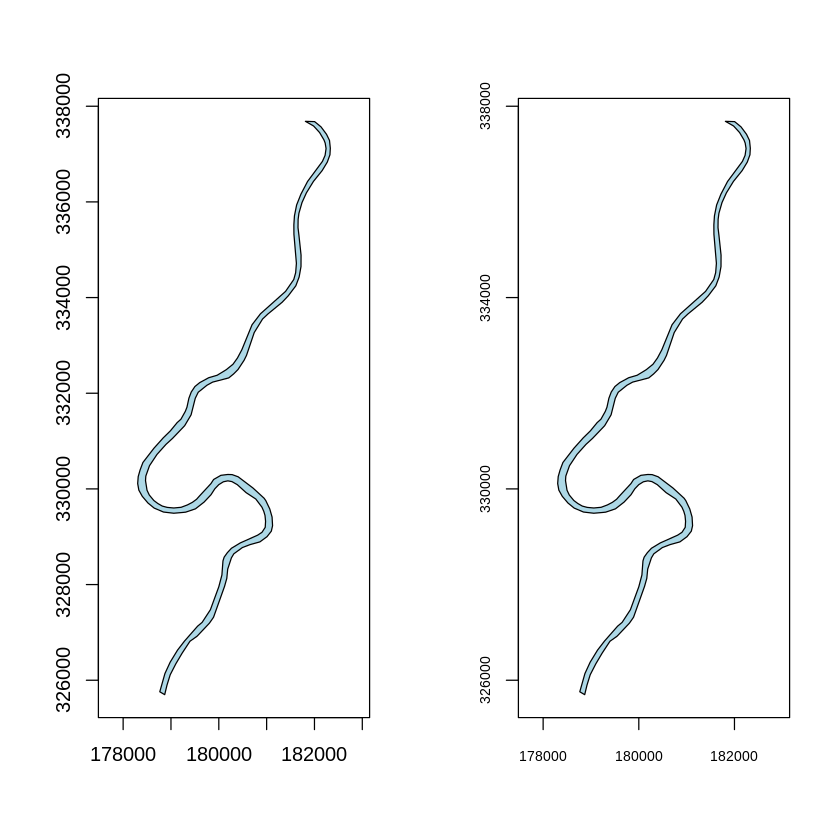

In [11]:
layout(matrix(c(1, 2), 1, 2))
plot(meuse.sr, col = "lightblue", axes = TRUE)
plot(meuse.sr, col = "lightblue", axes = FALSE)
axis(1, at = c(178000 + 0:2 * 2000), cex.axis = 0.7)
axis(2, at = c(326000 + 0:3 * 4000), cex.axis = 0.7)
box()

* If we want to include side effects on the next plot, **par** can be changed

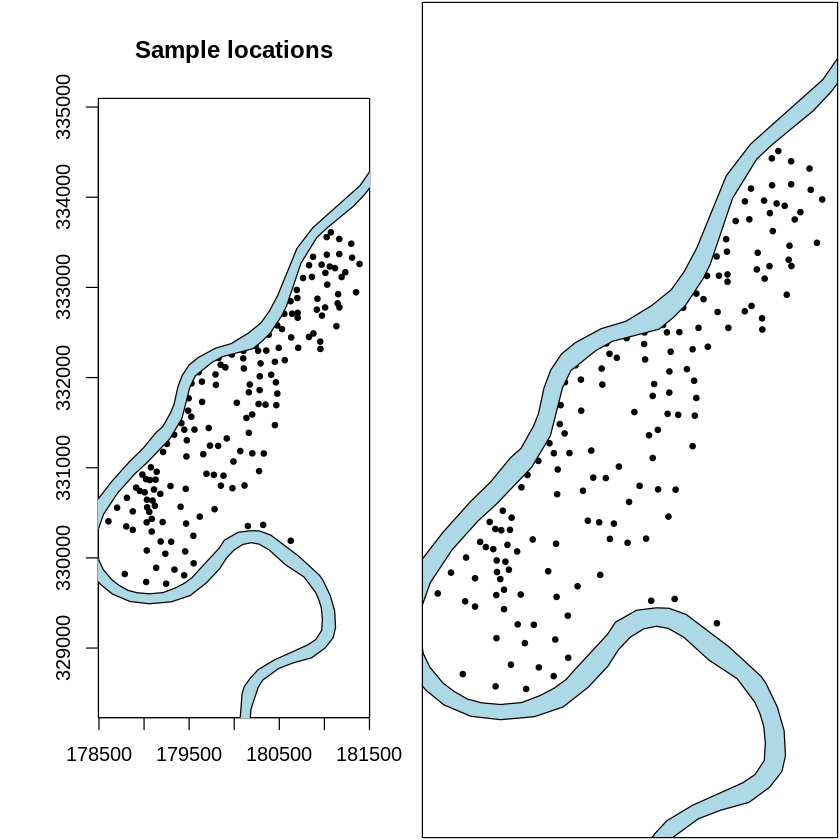

In [12]:
oldpar = par(no.readonly = TRUE) 
layout(matrix(c(1, 2), 1, 2))
plot(meuse, pch = 19, axes = TRUE, cex = 0.6)
plot(meuse.sr,  col = "lightblue", add = TRUE)
title("Sample locations")
par(mar = c(0, 0, 0, 0) + 0.1)
plot(meuse, pch = 19, axes = FALSE, cex = 0.6)
plot(meuse.sr,  col = "lightblue", add = TRUE)
box()


par(oldpar)

* A more common way represent a map is plotting a scale bar and a noth arrow using the **locator** command.

## Plot size, plotting area, map scale and multiple plots

R distinguishes between figure region (total figure size including azes, tittle, etc) and plotting region (area where the actual data are plotted)

To control the total size of the figure, we can set the figure size in incles

In [13]:
par("pin")
par(pin = c(4, 4))

[1] 5.426667 4.826667

* If the desire is to enlarge plotting window, we need to first close the current device and re-open with the new specified size

In [14]:
dev.off()
X11(width = 10, height = 10)

null device 
          1

* We can control the data area plotted by passing xlim and ylim in a plot command. (default extended with 4% on each side). To prevent the extension we can set par(xaxs='i') and par(yaxs="i")

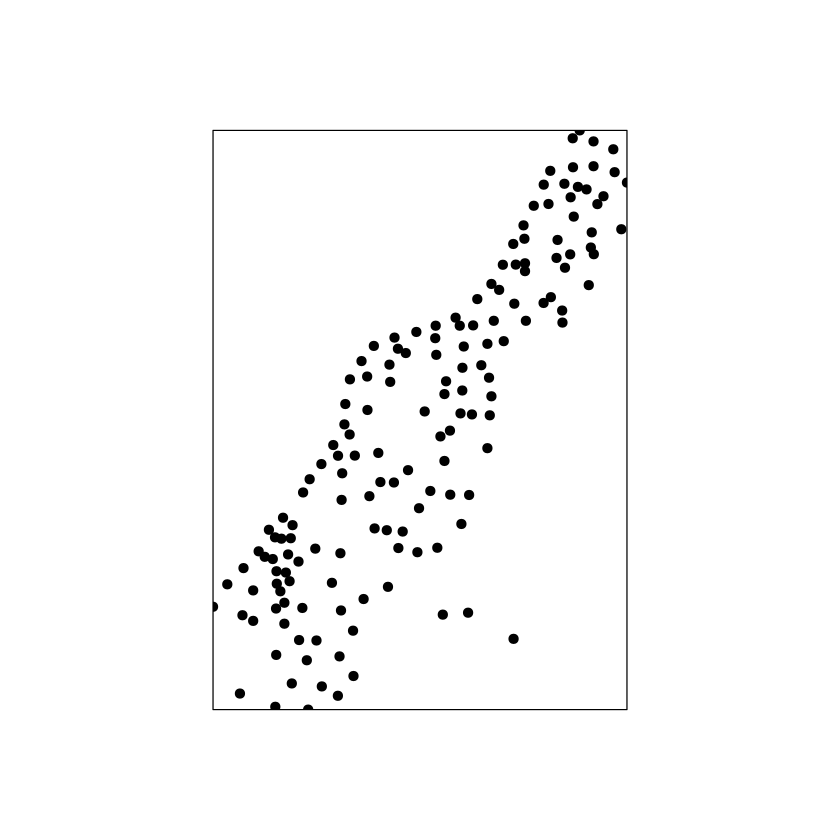

In [15]:
pin <- par("pin")
dxy <- apply(bbox(meuse), 1, diff)
# First we get the right aspect ratio according to the data points
ratio <- dxy[1]/dxy[2]

# Then plot the point without the 4% default expension
par(pin = c(ratio * pin[2], pin[2]), xaxs = "i", yaxs = "i")
plot(meuse, pch = 19)
box()

## Plotting attributes and map legends

* Up until now we were only concerned with plot geometry or topology of the spatial objects. However, often we will also want to see attributes of the object represented on the map.

* Next, we will explore more of the image method for the objects of class **SpatialPixelsDataFrame** and **SpatialGridDataFrame** to plot an interpolated zinc concentration (zinc.idw) as a background image along with the data

[using ordinary kriging]


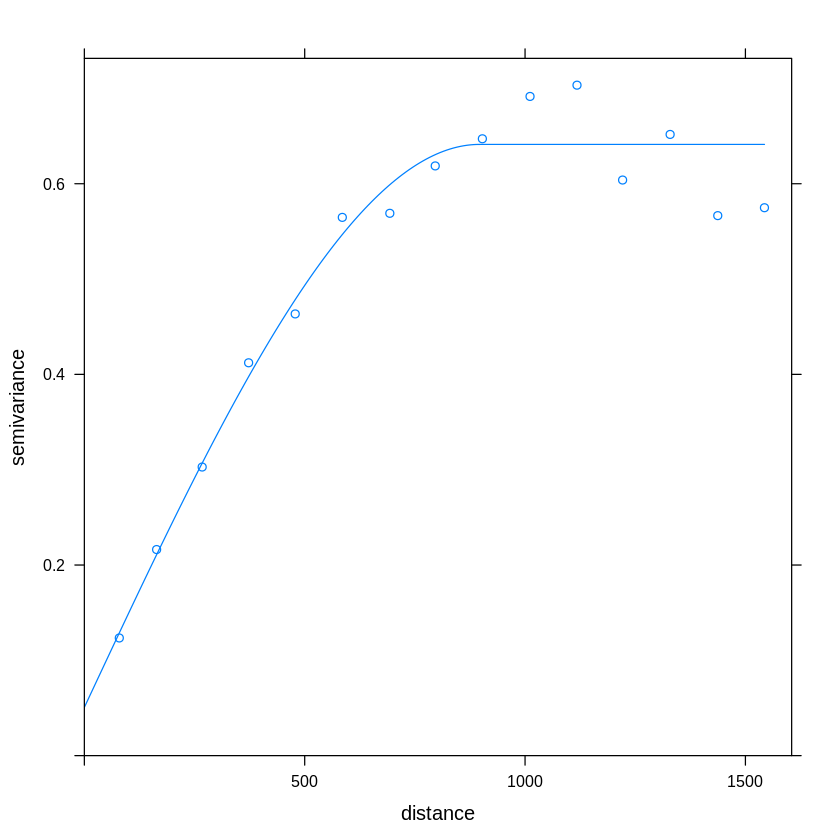

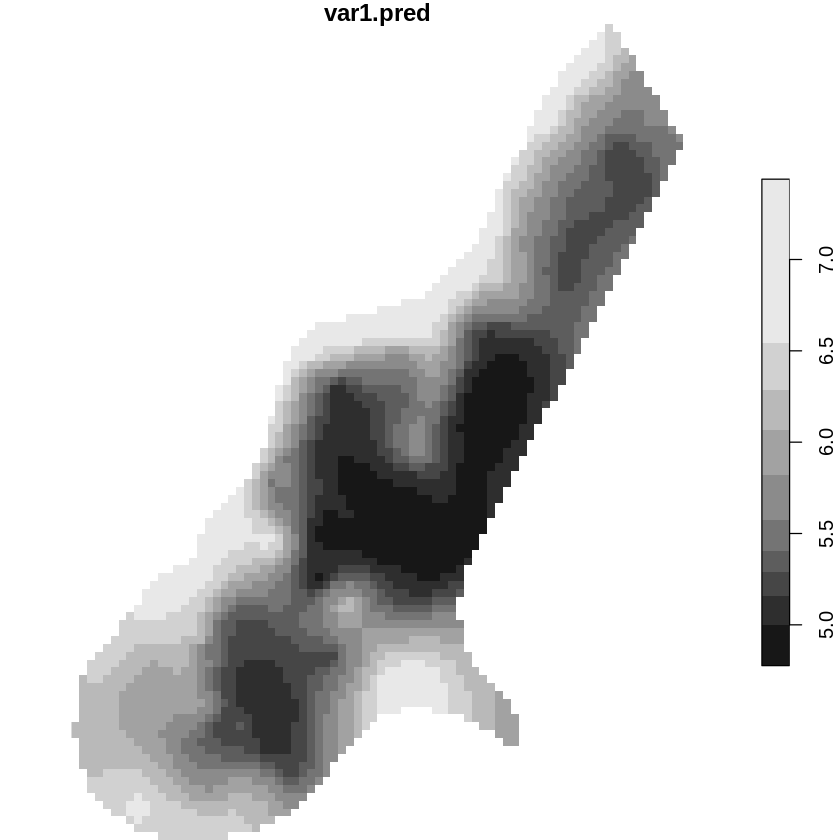

In [16]:
# First let's generate an interpolated (idw) file using inverted distance weight method. 
data(meuse)
# Setting coordinated on the data frame
coordinates(meuse) = ~x+y

# Creating grid
data(meuse.grid)
gridded(meuse.grid) = ~x+y

# Convert foreign object to an sf object
meuse <- st_as_sf(meuse)
# convert objects into a stars object
meuse.grid <- st_as_stars(meuse.grid)

# fitting model
v <- variogram(log(zinc)~1, meuse)
m <- fit.variogram(v, vgm(1, "Sph", 300, 1))
plot(v, model = m)

# Now based on model m, we can generate the idw file
zn.idw  <- krige(formula = log(zinc)~1, meuse, meuse.grid, model = m)
#> [using ordinary kriging]
plot(zn.idw[1])

Warning message in plot.sf(meuse, pch = 1, cex = sqrt(meuse$zinc)/20, add = TRUE):
“ignoring all but the first attribute”


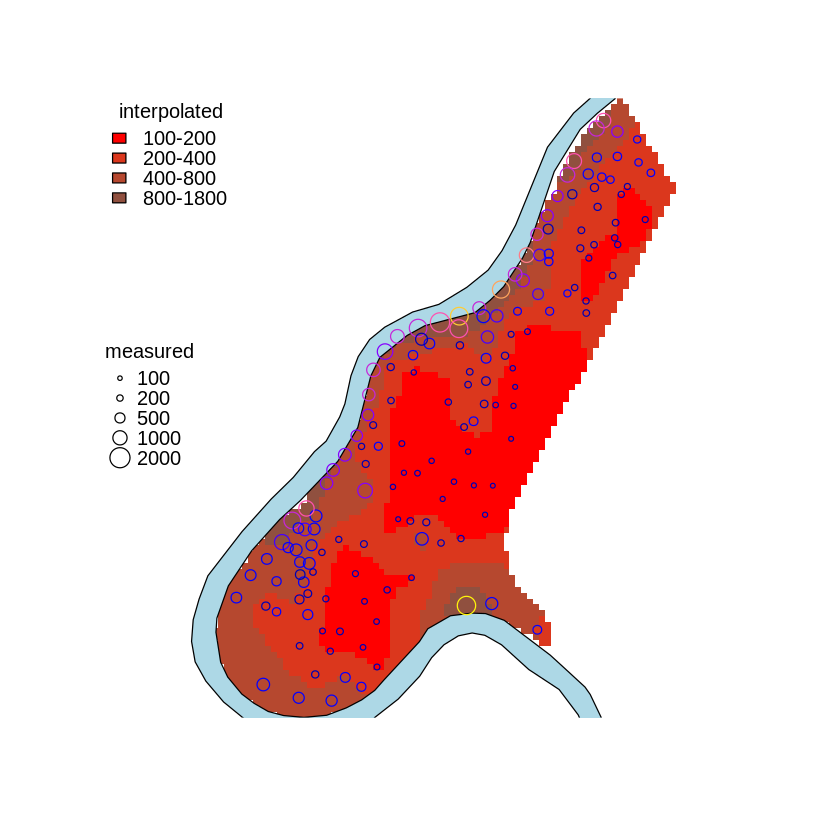

In [18]:
# Setting the color gradient (grey or colored)
#grays = gray.colors(4, 0.55, 0.95)
cc <- scales::seq_gradient_pal("red")(seq(0,1,length.out=4))



# Plot zinc attribute interpolated and plotted. 5 breaks and 4 colors
image(zn.idw, col = cc, breaks = log(c(100, 200, 400, 800, 1800)))
plot(meuse.sr, col = "lightblue", add = TRUE)

# Ploting attibutes
plot(meuse, pch = 1, cex = sqrt(meuse$zinc)/20, add = TRUE)

# legend of measured intervals
legVals <- c(100, 200, 500, 1000, 2000)
# plotting legend for zinc measures
legend("left", legend = legVals, pch = 1, pt.cex = sqrt(legVals)/20, 
       bty = "n", title = "measured")

# Adding legend to the interpolated data
legend("topleft", legend = c("100-200", "200-400", "400-800", "800-1800"), 
       fill = cc, bty = "n", title = "interpolated")

## A straight Trellis Example

Consider now two interpolation scenarios for the zinc variable in **meuse** data set: obtained on the **direct scale** and on the **inverte of the distance**


* First dealing with meuse: convert from data frame to SpatialPointsDataFrame

[1] "data.frame"

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

,x,y
5,181307,333330
6,181390,333260
7,181165,333370
8,181027,333363
9,181060,333231
10,181232,333168


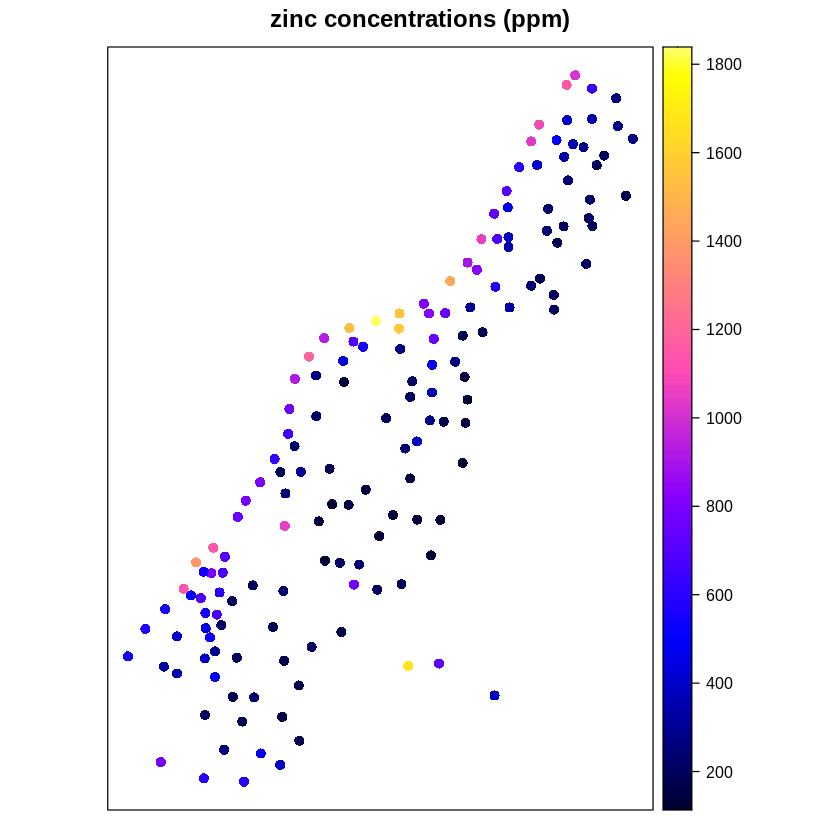

In [19]:
# data frame
data(meuse) 
class(meuse)

# promotes to SpatialPointsDataFrame
coordinates(meuse) = c("x", "y") 
class(meuse)
head(coordinates(meuse)[5:15,])

# Visualize data using spplot
spplot(meuse, "zinc",  colorkey = TRUE, main = "zinc concentrations (ppm)")

* Second dealing with meuse.grid: convert from data frame to SpatialPointsDataFrame

[1] "data.frame"

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "SpatialPixelsDataFrame"
attr(,"package")
[1] "sp"

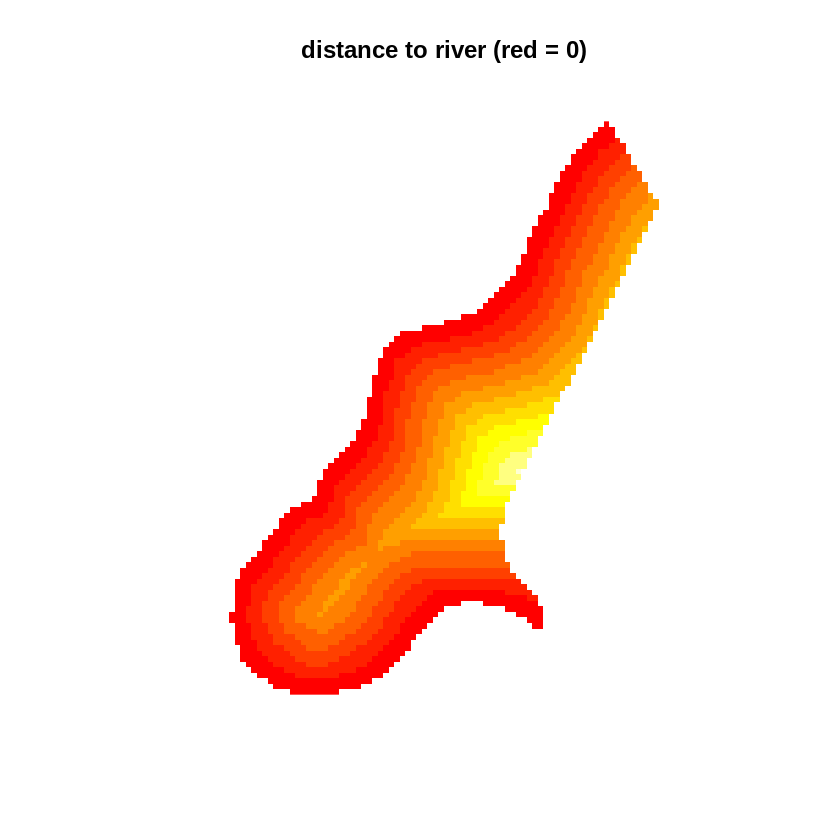

In [20]:
# data frame
data(meuse.grid) 
class(meuse.grid)


# promotes to SpatialPointsDataFrame and then to SpatialPixelsDataFrame
coordinates(meuse.grid) = c("x", "y") 
class(meuse.grid)
gridded(meuse.grid) = TRUE
class(meuse.grid)

# Visualize grid data
image(meuse.grid["dist"])
title("distance to river (red = 0)")

* Interpolate data using idw (inverse distance weighted interpolation) method


[inverse distance weighted interpolation]


[1] "SpatialPixelsDataFrame"
attr(,"package")
[1] "sp"

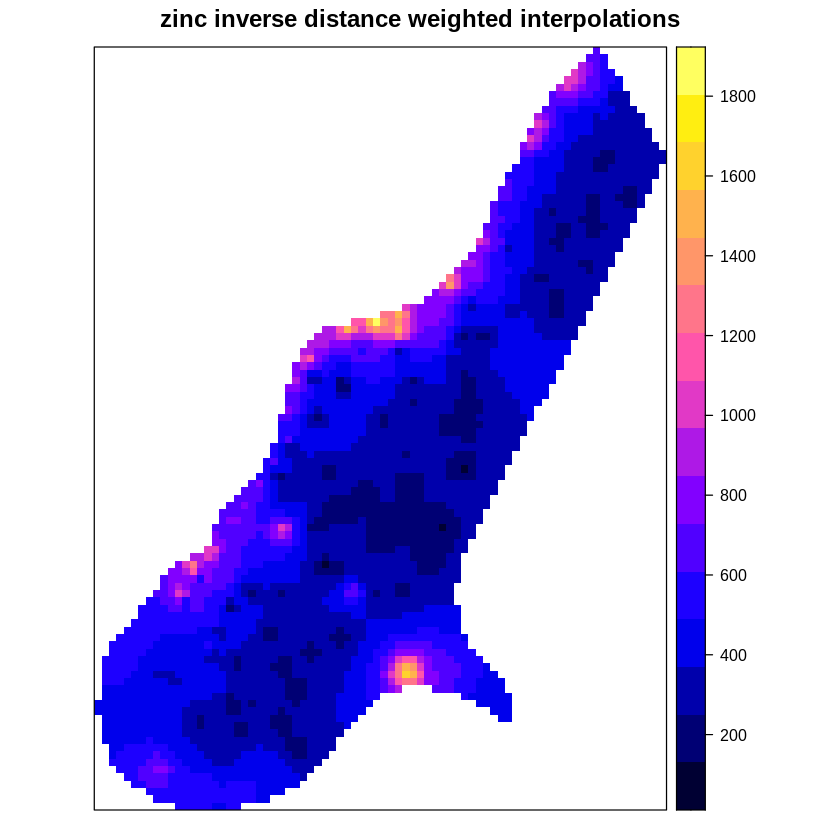

In [21]:
zinc.idw <- idw(zinc~1, meuse, meuse.grid)
class(zinc.idw)

# Visualize the interpolation
spplot(zinc.idw["var1.pred"], main = "zinc inverse distance weighted interpolations")

* Generate a variogram assuming a constant trend from the variable log(zinc)

,np,dist,gamma,dir.hor,dir.ver,id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,57,79.29244,0.1234479,0,0,var1
2,299,163.97367,0.2162185,0,0,var1
3,419,267.36483,0.3027859,0,0,var1
4,457,372.73542,0.4121448,0,0,var1
5,547,478.47670,0.4634128,0,0,var1
6,533,585.34058,0.5646933,0,0,var1


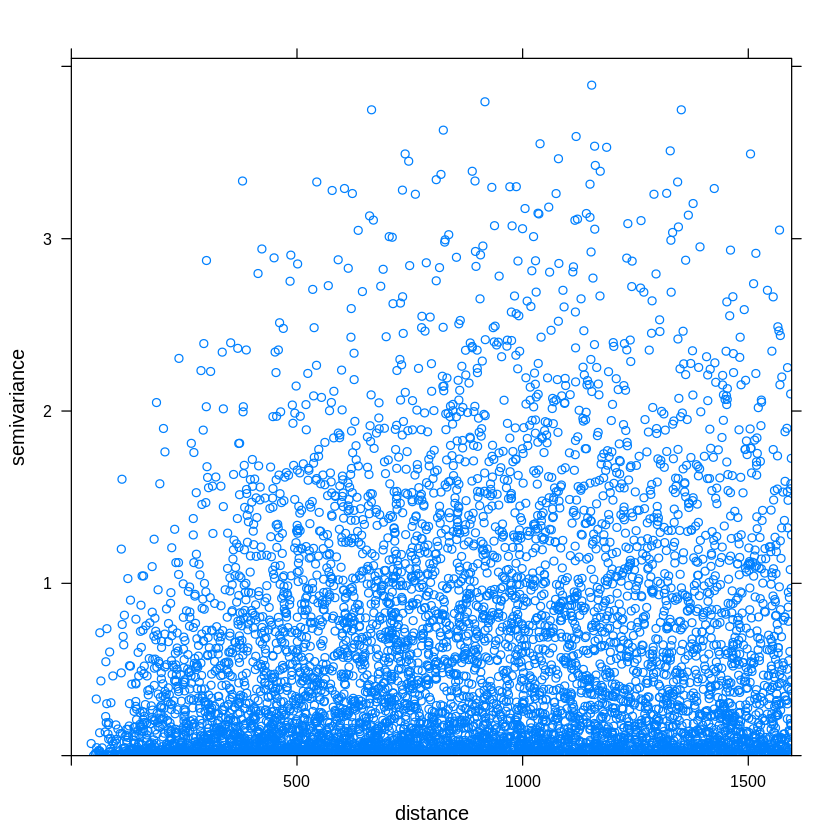

In [23]:
vgm1 <- variogram(log(zinc) ~ 1, meuse)

# plotting the variogram cloud
plot(variogram(log(zinc) ~ 1, meuse, cloud = TRUE))

# Check parameter
head(vgm1)

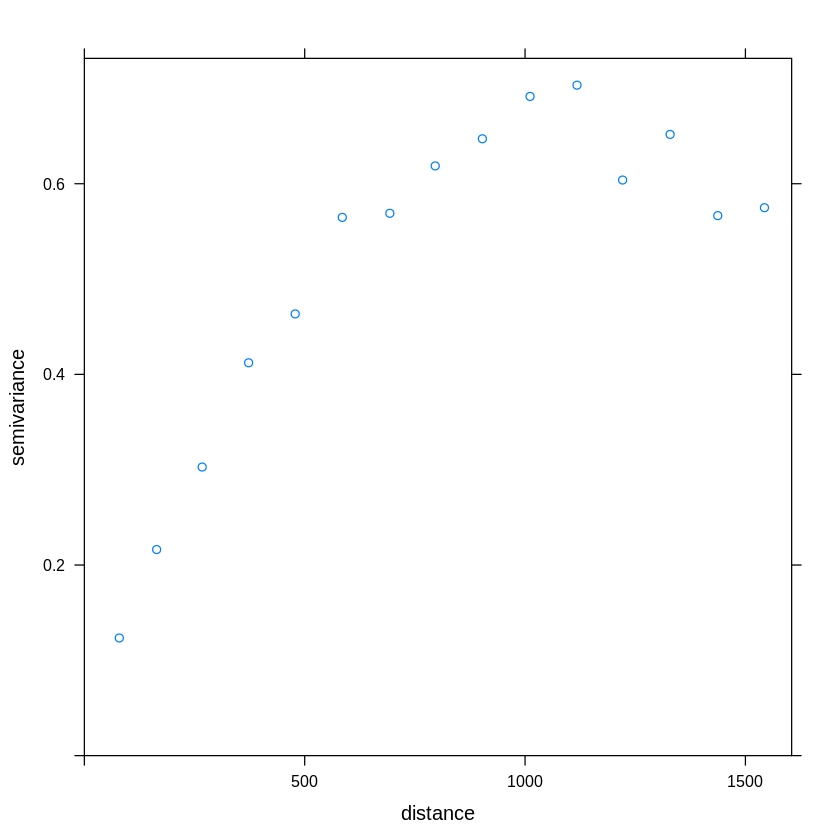

In [24]:
# plot vgm1
plot(vgm1)

* now let's fit a theoretical variogram

,model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Nug,0.05066243,0.0000,0.0,0,0,0,1,1
2,Sph,0.59060780,897.0209,0.5,0,0,0,1,1


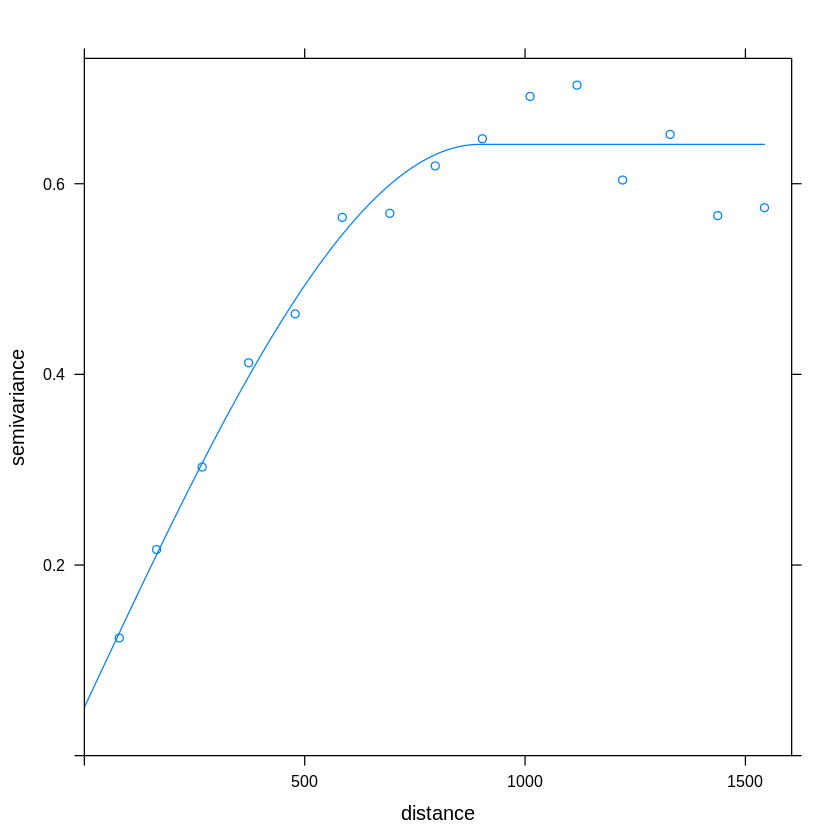

In [25]:
vgm1.fit <- fit.variogram(vgm1, model = vgm(1, "Sph", 900, 1))
vgm1.fit


# plot the fitted variogram and the observed variogram on the same graph
plot(vgm1, vgm1.fit)

In [26]:
# kriggging
zn <- krige(zinc~1,meuse,meuse.grid)

# Generate a column with raw estimator 
zn$direct <- zn$var1.pred
# Generate a column with log estimator 
zn$log <- exp(krige(log(zinc)~1,meuse,meuse.grid)$var1.pred)

[inverse distance weighted interpolation]
[inverse distance weighted interpolation]


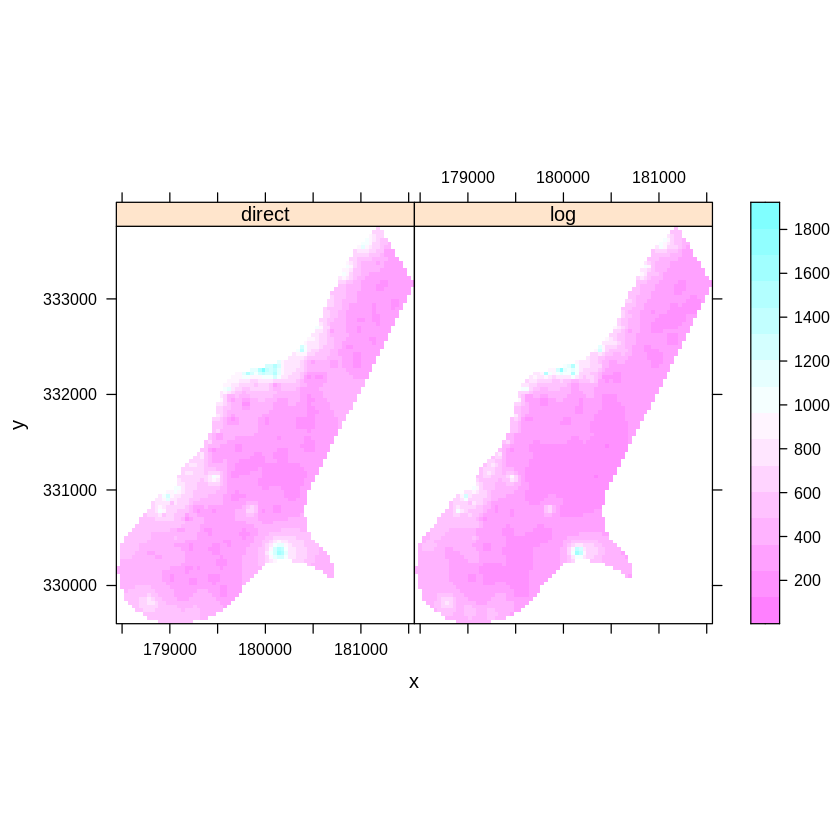

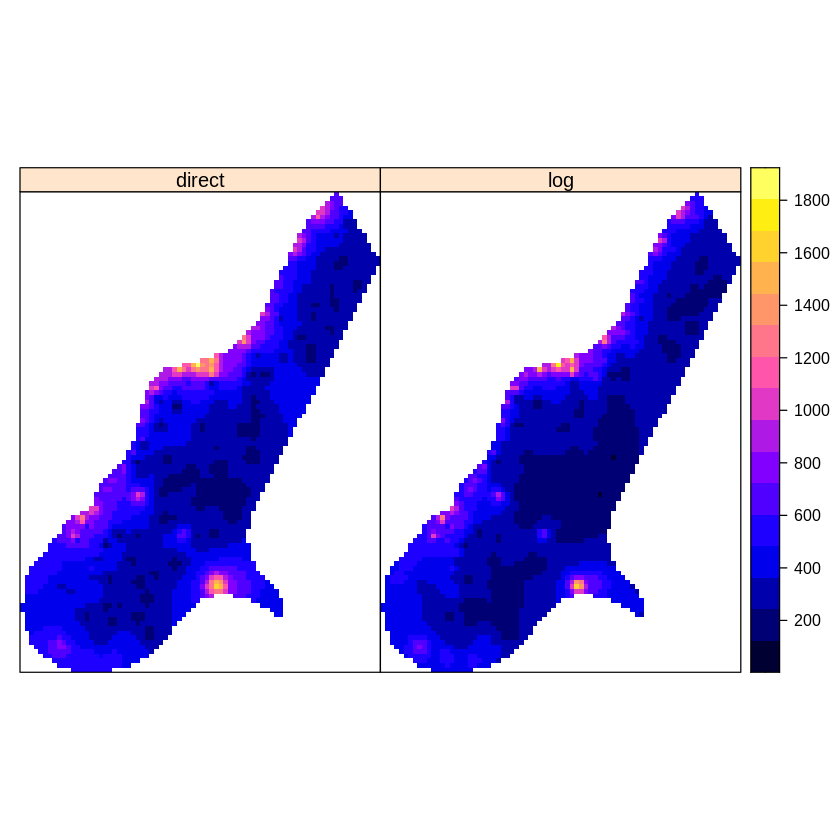

In [27]:
# Plotting using two different methods:
# levelplot
levelplot(z ~ x + y | name,
          spmap.to.lev(zn[c("direct","log")]),
          asp = "iso")

# spplot:
spplot(zn[c("direct","log")])

## Plotting Points, Lines, Polygons, and Grids

Function **ssplot** plot spatial objects using color (or grey tone) to denote attribute values.


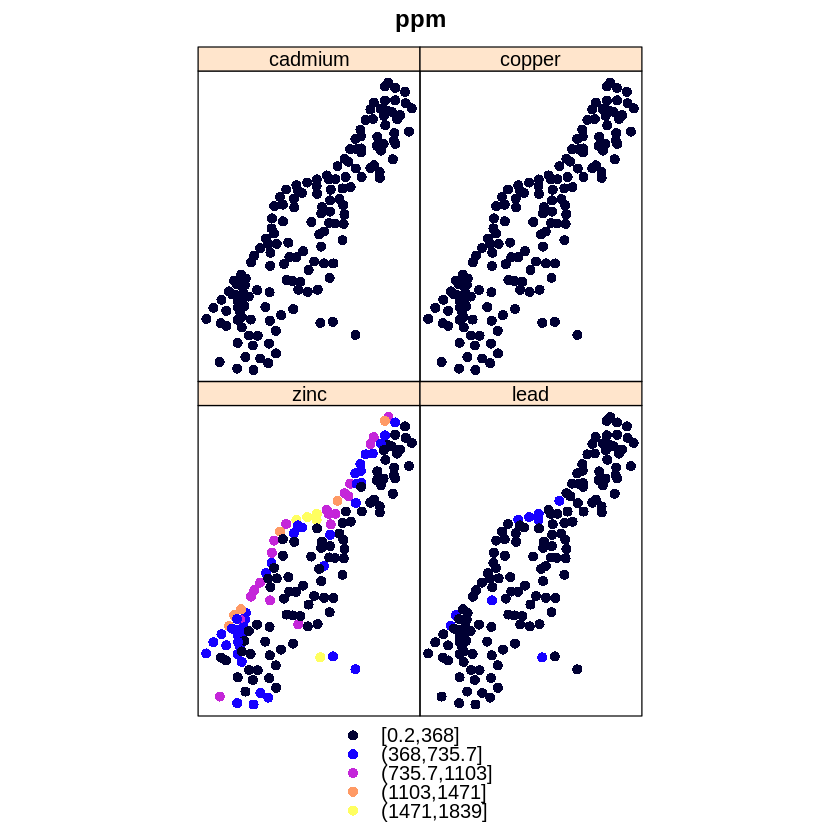

In [28]:
spplot(meuse, c("zinc","lead","cadmium","copper"), main = "ppm")

* Next, an example of **SpatialLinesDataFrame** plot using the function **contourLines** to calculate the contourlines 

In [29]:
library(maptools)

Checking rgeos availability: TRUE



[1] "SpatialPixelsDataFrame"
attr(,"package")
[1] "sp"

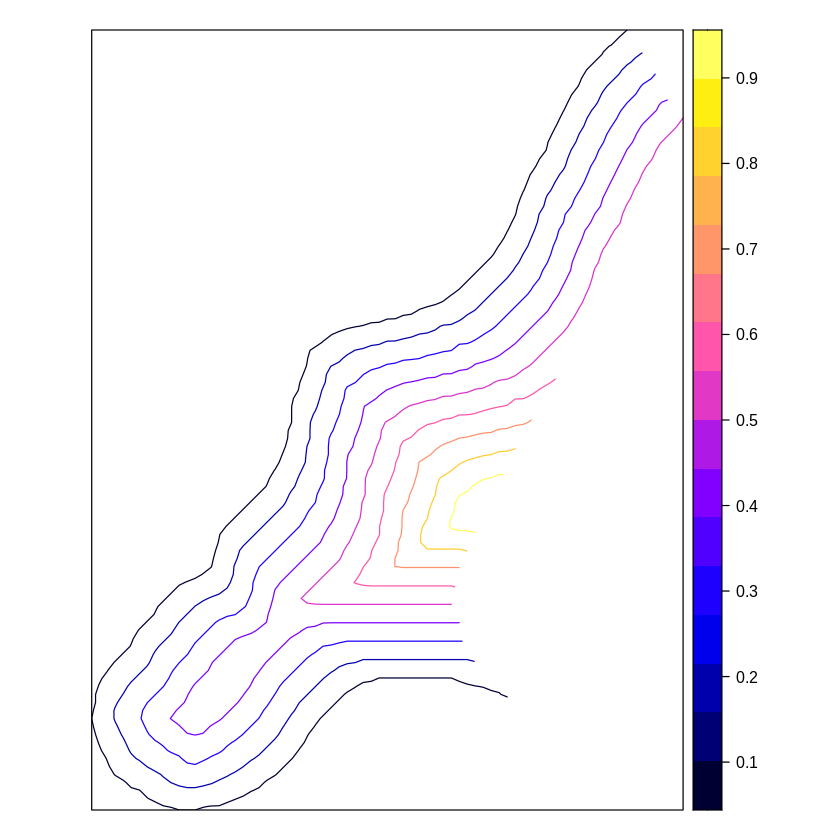

In [30]:
# The result should be 'SpatialPixelsDataFrame'
class(meuse.grid)
#Image or contour method for gridded spatial data
im <- as.image.SpatialGridDataFrame(meuse.grid["dist"])
# Calculate contourlines and convert
cl <- ContourLines2SLDF(contourLines(im))
spplot(cl)

## Adding References and Layout Elements to Plots

The method spplot take a single argument, sp.layout, to annotate plots with lines, points, grids, polygons, text, or combinations of these

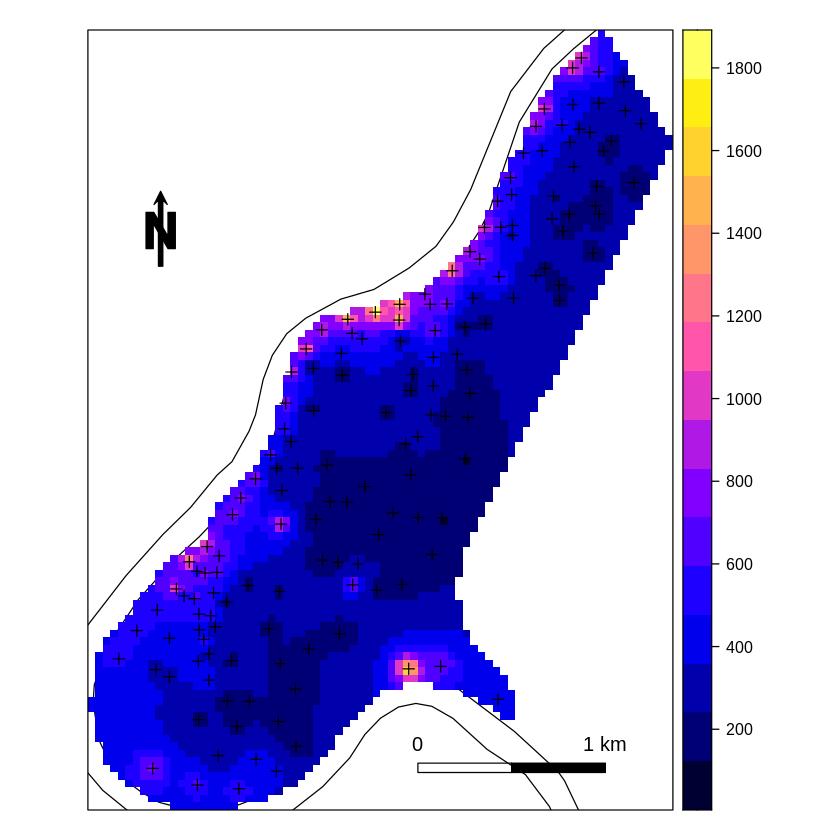

In [31]:
# River
river <- list("sp.polygons", meuse.sr)
# Arrow to north direction
north <- list("SpatialPolygonsRescale", layout.north.arrow(), 
                                        offset = c(178750, 332500), 
                                        scale = 400)
# scale
scale <- list("SpatialPolygonsRescale", layout.scale.bar(), 
                                       offset = c(180200, 329800), 
                                       scale = 1000, fill = c("transparent", "black"))
# Text for the scale
txt1 <- list("sp.text", c(180200, 329950), "0")
txt2 <- list("sp.text", c(181200, 329950), "1 km")

# Points where the soil was sampled

pts <- list("sp.points",
            meuse,
            pch = 3, col = "black")

# Combining in a layout list
meuse.layout <- list(river, north, scale, txt1, txt2, pts)

#Plot
spplot(zn["log"], sp.layout = meuse.layout)


## Interacting with Base Graphics

Basic graphs has two functions to interact with interactive graphic devices:
   * locator: returns the location of points clicked
   * idenfify: plots and returns the labels of the items nearest to the location clicked
   Both functions wait tof the user input. Left click are registered and right click ends the input.
   
   
## Color Palettes and Class intervals

several color palettes are available in R:
   * rainbow
   * grey.colors
   * heat.colors
   * terrain.colors
   * topo.colors
   * cm.colors
   
For quantitative data, shades in a single color are usually preferred. These can be created by **colorRampPalette** which creates a color interpolating function taking the required number of shades as arguments.

The package **RColorBrewer** provides the palettes for continous, diverging, categorical variable.

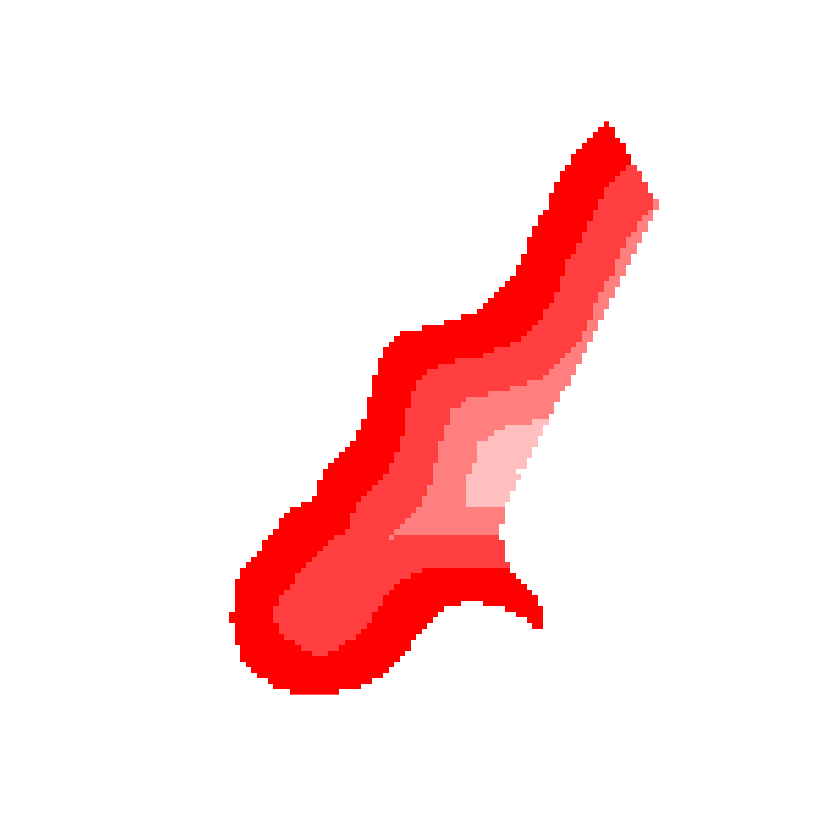

In [32]:
rw.colors <- colorRampPalette(c("red", "white"))
image(meuse.grid["dist"], col = rw.colors(5))

In [53]:
#library(RColorBrewer)
#example(brewer.pal)

## Class Intervals
 
Class inteval can be chosen in many ways (**classInt** package). Two styles are the quantiles and Fisher-Jenks natural breaks for five classes. We can use the function **classIntervals** to select intervals.

style: quantile
  one of 14,891,626 possible partitions of this variable into 5 classes
  [113,186.8) [186.8,246.4) [246.4,439.6) [439.6,737.2)  [737.2,1839] 
           31            31            31            31            31 

[1]   73.8   59.6  193.2  297.6 1101.8

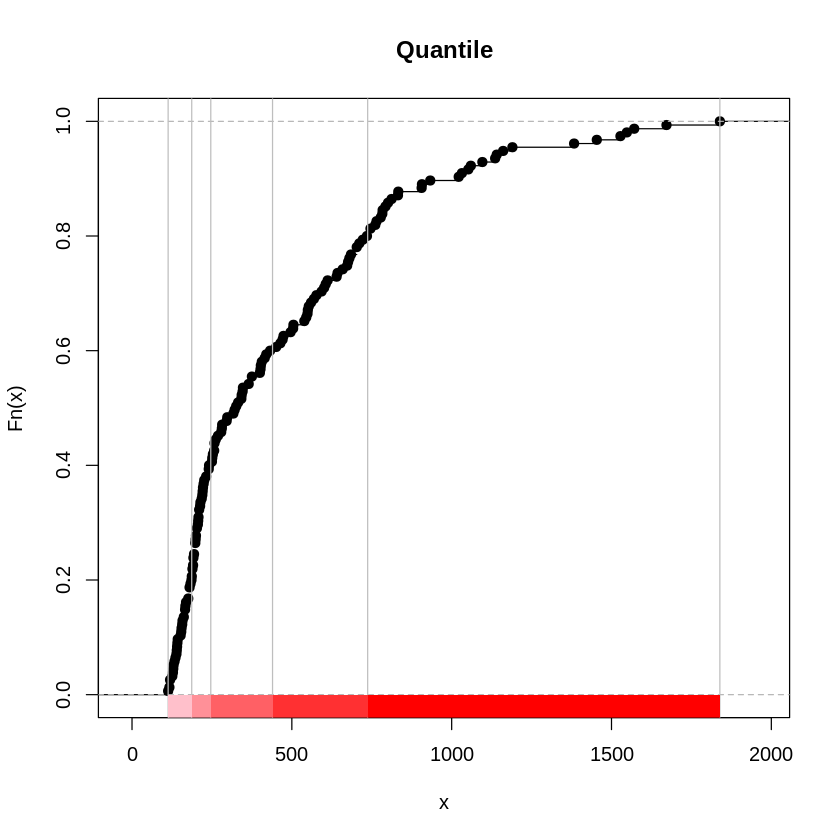

In [33]:
library(RColorBrewer)
library(classInt)

# 4 tonalities of grey
#pal <- grey.colors(4, 0.95, 0.55, 2.2)
rw.colors <- colorRampPalette(c("pink", "red"))


# Producing 5 inteval classes (color +1)
q5 <- classIntervals(meuse$zinc, n = 5, style = "quantile")
q5

# breaks
diff(q5$brks)
plot(q5, pal = rw.colors(5), main= "Quantile")



style: fisher
  one of 14,891,626 possible partitions of this variable into 5 classes
   [113,307.5)    [307.5,573)    [573,869.5) [869.5,1286.5)  [1286.5,1839] 
            75             32             29             12              7 

[1] 194.5 265.5 296.5 417.0 552.5

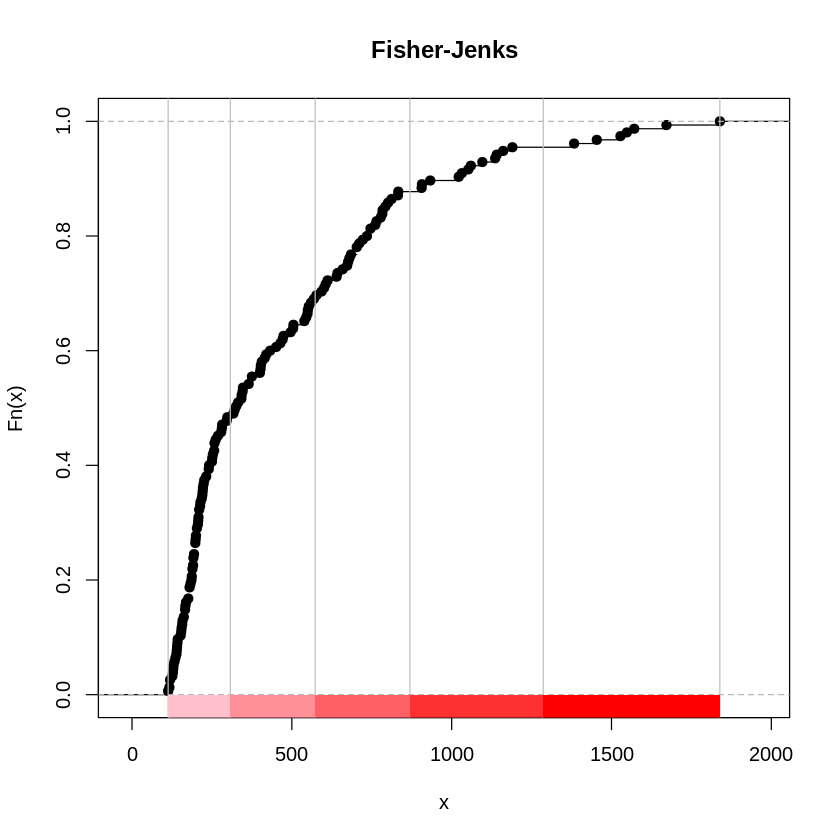

In [34]:

fj5 <- classIntervals(meuse$zinc, n = 5, style = "fisher")
fj5
diff(fj5$brks)
plot(fj5, pal = rw.colors(5), main="Fisher-Jenks")

* Once finding the right number intervals, we can chose the color palette and plot the data using **findColours** function

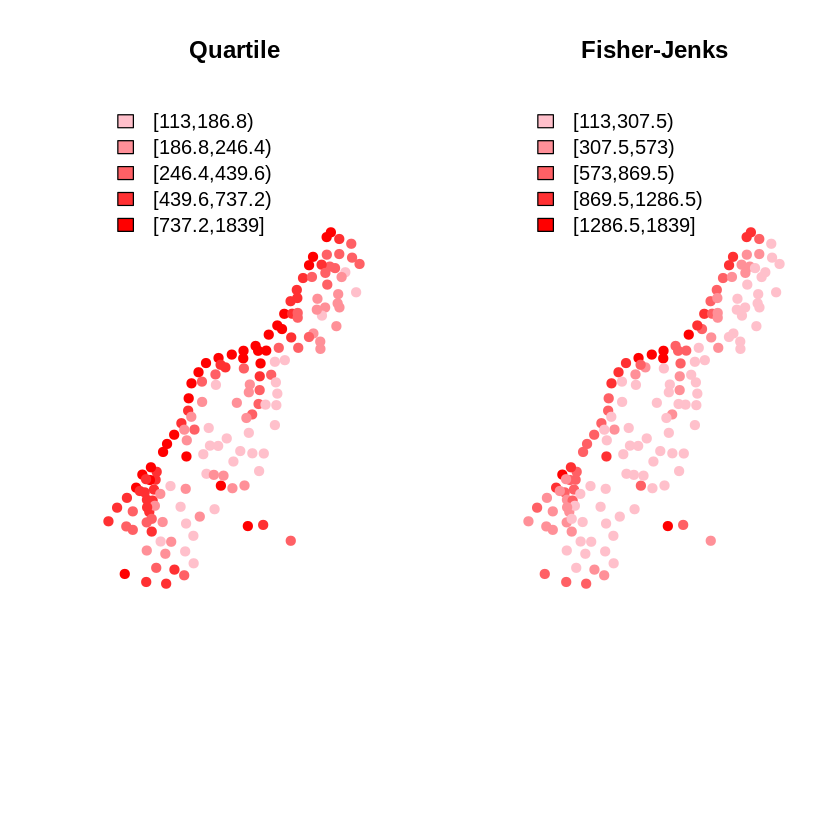

In [35]:
par(mfrow=c(1,2))
q5Colours <- findColours(q5, rw.colors(5))
plot(meuse, col = q5Colours, pch = 19, main = "Quartile")

legend("topleft", fill = attr(q5Colours, "palette"), 
       legend = names(attr(q5Colours, "table")), bty = "n")

fj5Colours <- findColours(fj5, rw.colors(5))
plot(meuse, col = fj5Colours, pch = 19, main = "Fisher-Jenks")

legend("topleft", fill = attr(fj5Colours, "palette"), 
       legend = names(attr(fj5Colours, "table")), bty = "n")